In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('../data/raw/electric-chargepoint-analysis-2017-raw-domestics-data (1).csv')

print(f"📊 Dataset loaded: {df.shape[0]:,} charging sessions")
print(f"📅 Columns: {list(df.columns)}")
df.head()


📊 Dataset loaded: 1,048,575 charging sessions
📅 Columns: ['ChargingEvent', 'CPID', 'StartDate', 'StartTime', 'EndDate', 'EndTime', 'Energy', 'PluginDuration']


,ChargingEvent,CPID,StartDate,StartTime,EndDate,EndTime,Energy,PluginDuration
0,15045471,AN02343,26/09/2017,22:12:00,26/09/2017,22:16:00,0.4,0.0
1,15045072,AN03348,26/09/2017,21:34:00,26/09/2017,21:40:00,0.4,0.0
2,15045044,AN07961,26/09/2017,21:40:00,26/09/2017,21:49:00,0.6,0.0
3,15045197,AN02488,26/09/2017,21:57:00,26/09/2017,22:54:00,7.1,1.0
4,15045448,AN09719,26/09/2017,22:07:00,26/09/2017,23:10:00,1.6,1.0


In [8]:
# Combine date and time columns
df['start_datetime'] = pd.to_datetime(df['StartDate'] + ' ' + df['StartTime'], 
                                     format='%d/%m/%Y %H:%M:%S', errors='coerce')

# Extract hour from start time
df['start_hour'] = df['start_datetime'].dt.hour

# Clean data
df_clean = df.dropna(subset=['start_datetime', 'start_hour'])

print(f"✅ Clean data: {len(df_clean):,} sessions")
print(f"📅 Date range: {df_clean['start_datetime'].min()} to {df_clean['start_datetime'].max()}")


✅ Clean data: 1,048,575 sessions
📅 Date range: 2017-09-26 21:25:00 to 2017-12-31 23:59:23


In [9]:
# Count sessions by hour
hourly_sessions = df_clean['start_hour'].value_counts().sort_index()
total_sessions = hourly_sessions.sum()

print("📊 Charging Sessions by Hour:")
print(f"{'Hour':<6} {'Sessions':<10} {'%':<8} {'Pattern':<15}")
print("-" * 45)

for hour in range(24):
    sessions = hourly_sessions.get(hour, 0)
    percentage = (sessions / total_sessions) * 100
    
    # Visual pattern
    bar_length = int((sessions / hourly_sessions.max()) * 10)
    pattern = "█" * bar_length
    
    # Peak indicator
    if percentage > 6:
        indicator = "🔴"
    elif percentage > 4:
        indicator = "🟡"
    else:
        indicator = "🟢"
    
    print(f"{hour:2d}:00  {sessions:8d}  {percentage:6.1f}%  {pattern:<10} {indicator}")


📊 Charging Sessions by Hour:
Hour   Sessions   %        Pattern        
---------------------------------------------
 0:00     17842     1.7%  █          🟢
 1:00      5982     0.6%             🟢
 2:00      3495     0.3%             🟢
 3:00      2927     0.3%             🟢
 4:00      3744     0.4%             🟢
 5:00      4712     0.4%             🟢
 6:00      8905     0.8%             🟢
 7:00     18344     1.7%  █          🟢
 8:00     31280     3.0%  ██         🟢
 9:00     35468     3.4%  ███        🟢
10:00     37066     3.5%  ███        🟢
11:00     44067     4.2%  ███        🟡
12:00     47641     4.5%  ████       🟡
13:00     49364     4.7%  ████       🟡
14:00     51169     4.9%  ████       🟡
15:00     73353     7.0%  ██████     🔴
16:00     94499     9.0%  ████████   🔴
17:00    115927    11.1%  ██████████ 🔴
18:00    113964    10.9%  █████████  🔴
19:00     89240     8.5%  ███████    🔴
20:00     69050     6.6%  █████      🔴
21:00     59071     5.6%  █████      🟡
22:00     45925     4.4%

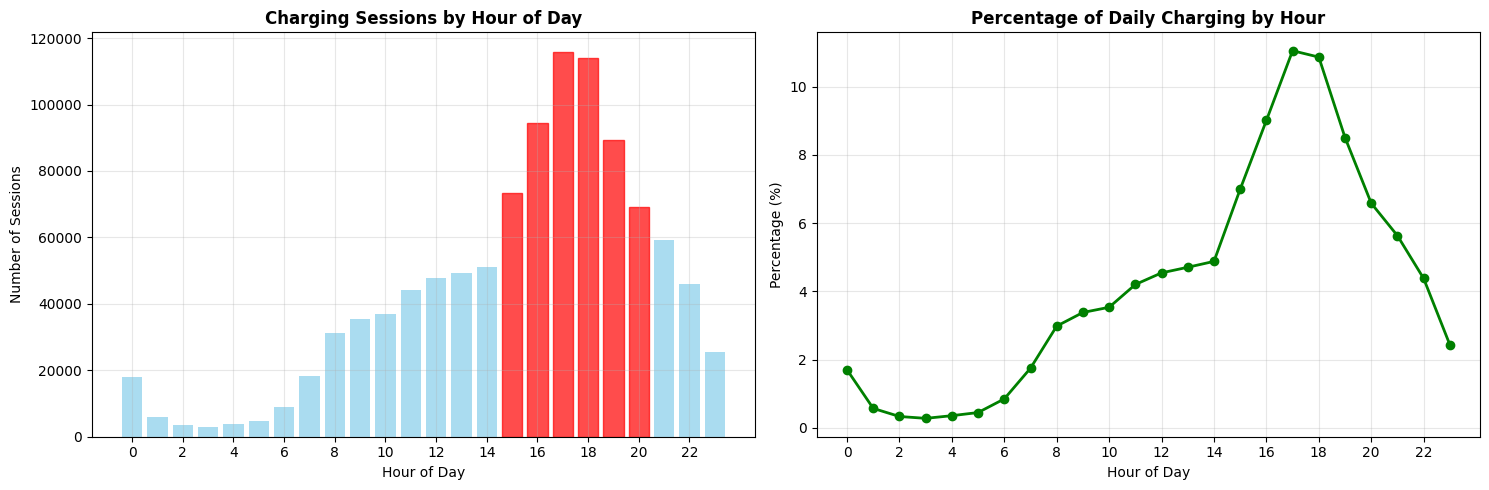

In [10]:
# Create hourly pattern visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Sessions by hour
hours = range(24)
sessions_by_hour = [hourly_sessions.get(h, 0) for h in hours]

bars = ax1.bar(hours, sessions_by_hour, color='skyblue', alpha=0.7)
ax1.set_title('Charging Sessions by Hour of Day', fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Sessions')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)

# Highlight peak hours (top 25%)
peak_threshold = np.percentile(sessions_by_hour, 75)
for i, bar in enumerate(bars):
    if sessions_by_hour[i] > peak_threshold:
        bar.set_color('red')

# Percentage by hour
percentages = [(sessions_by_hour[h] / sum(sessions_by_hour)) * 100 for h in range(24)]
ax2.plot(hours, percentages, marker='o', linewidth=2, markersize=6, color='green')
ax2.set_title('Percentage of Daily Charging by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Percentage (%)')
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Identify peak hours using different methods
sessions_series = pd.Series([hourly_sessions.get(h, 0) for h in range(24)], index=range(24))

# Method 1: Top 25%
top_25_threshold = sessions_series.quantile(0.75)
top_25_peaks = sessions_series[sessions_series > top_25_threshold].index.tolist()

# Method 2: Above 5% of total
above_5pct = sessions_series[(sessions_series / sessions_series.sum()) > 0.05].index.tolist()

print("🎯 Peak Hours Identification:")
print(f"Top 25% method: {sorted(top_25_peaks)}")
print(f"Above 5% method: {sorted(above_5pct)}")

# Show the actual percentages for top hours
print(f"\n📊 Top Hours:")
top_hours = sessions_series.nlargest(8)
for hour, sessions in top_hours.items():
    pct = (sessions / sessions_series.sum()) * 100
    print(f"  {hour:2d}:00 - {sessions:,} sessions ({pct:.1f}%)")


🎯 Peak Hours Identification:
Top 25% method: [15, 16, 17, 18, 19, 20]
Above 5% method: [15, 16, 17, 18, 19, 20, 21]

📊 Top Hours:
  17:00 - 115,927 sessions (11.1%)
  18:00 - 113,964 sessions (10.9%)
  16:00 - 94,499 sessions (9.0%)
  19:00 - 89,240 sessions (8.5%)
  15:00 - 73,353 sessions (7.0%)
  20:00 - 69,050 sessions (6.6%)
  21:00 - 59,071 sessions (5.6%)
  14:00 - 51,169 sessions (4.9%)


In [6]:
# Our current peak hours from simulation
current_peak_hours = [7, 8, 9, 10, 17, 18, 19, 20, 21]

# Real data peak hours (using above 5% method)
real_peak_hours = above_5pct

print("⚖️ Comparison:")
print(f"Current simulation: {current_peak_hours}")
print(f"Real data peaks:    {sorted(real_peak_hours)}")

# Calculate overlap
overlap = set(current_peak_hours) & set(real_peak_hours)
missing = set(real_peak_hours) - set(current_peak_hours)
extra = set(current_peak_hours) - set(real_peak_hours)

print(f"\n✅ Correct: {sorted(overlap)}")
print(f"❌ Missing: {sorted(missing)}")
print(f"⚠️ Extra:   {sorted(extra)}")

accuracy = len(overlap) / len(set(current_peak_hours) | set(real_peak_hours)) * 100
print(f"\n📈 Accuracy: {accuracy:.1f}%")


⚖️ Comparison:
Current simulation: [7, 8, 9, 10, 17, 18, 19, 20, 21]
Real data peaks:    [15, 16, 17, 18, 19, 20, 21]

✅ Correct: [17, 18, 19, 20, 21]
❌ Missing: [15, 16]
⚠️ Extra:   [7, 8, 9, 10]

📈 Accuracy: 45.5%


In [7]:
# Final recommendations
recommended_peaks = sorted(real_peak_hours)

print("💡 RECOMMENDATIONS:")
print(f"Recommended peak hours: {recommended_peaks}")

# Convert to ranges for config
ranges = []
start = recommended_peaks[0]
for i in range(1, len(recommended_peaks)):
    if recommended_peaks[i] != recommended_peaks[i-1] + 1:
        ranges.append((start, recommended_peaks[i-1]))
        start = recommended_peaks[i]
ranges.append((start, recommended_peaks[-1]))

print(f"\n⚙️ Config update:")
print(f"'peak_hours': {ranges}")

# Impact analysis
current_coverage = sum(sessions_series[h] for h in current_peak_hours) / sessions_series.sum() * 100
recommended_coverage = sum(sessions_series[h] for h in recommended_peaks) / sessions_series.sum() * 100

print(f"\n📊 Coverage:")
print(f"Current:     {current_coverage:.1f}% of real charging")
print(f"Recommended: {recommended_coverage:.1f}% of real charging")
print(f"Improvement: {recommended_coverage - current_coverage:+.1f} percentage points")


💡 RECOMMENDATIONS:
Recommended peak hours: [15, 16, 17, 18, 19, 20, 21]

⚙️ Config update:
'peak_hours': [(15, 21)]

📊 Coverage:
Current:     54.3% of real charging
Recommended: 58.7% of real charging
Improvement: +4.4 percentage points
